In [16]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, LSTM, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.initializers import Ones
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import numpy as np
import pandas as pd
import re
from matplotlib import rcParams  # next 3 lines set font family for plotting
rcParams['font.family'] = 'serif'
#rcParams['font.sans-serif'] = ['Times New Roman']
rcParams['font.serif'] = ['Optima']
import matplotlib.pyplot as plt
import os
import time
from random import shuffle

from keras.optimizers import Adagrad

In [11]:
#%% SETTINGS FOR REPRODUCIBLE RESULTS DURING DEVELOPMENT

import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

#import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [12]:
# read in and preprocess data

Xstatic = pd.read_csv('pulse2d_iterinput.txt', sep='\t')  # read in static inputs (Dx, Dy, C0, etc...)
wd = os.getcwd()  # set current directory as working directory path
out_lst = [f for f in os.listdir(wd) if re.match('pulse2d_iteroutput[0-9]*.txt', f)]  # create list of filenames for output files of iterative runs
data = pd.read_csv(out_lst[0], sep='\t')  # read in the first output to get the shape
Nsamples = 1000  # number of samples for all I/O is equal to the number of iterative runs
Ntimesteps = data.shape[0]  # number of 'timesteps', in this case is equal to the number of domain nodes
XNfeatures = data.shape[1]-1  # three output sequences will be used as input to the network to drive the LSTM
XSNfeatures = Xstatic.shape[1]  # static features
YNfeatures = 1  # only one prediction of interest....(Cmax)
Xdim2D = (Nsamples,Ntimesteps*XNfeatures)  # dimension for 2D dynamic input
Ydim2D = (Nsamples,Ntimesteps*YNfeatures)  # dimension for 2D output
X2D = np.zeros(Xdim2D)  # initialize 2D dynamic input as numpy array of zeros
Y2D = np.zeros(Ydim2D)  # initialize 2D dynamic output...
Xdim3D = (Nsamples,Ntimesteps,XNfeatures)  # dimension for 3D dynamic input
Ydim3D = (Nsamples,Ntimesteps,YNfeatures)  # dimension for 3D output
X3D = np.zeros(Xdim3D)  # initialize 3D dynamic input as numpy array of zeros
Y3D = np.zeros(Ydim3D)  # initialize 3D output....

# build X and Y - read in dynamic I/O...i.e. output from the pulse2D model. The output has four predictions total, only one of which is the desired prediciton (Cmax = max concentration at domain node d). The remaining predictions will be used as input to the LSTM.
for i,f in enumerate(out_lst):
    data = pd.read_csv(f, sep='\t')
    X3D[i,:,:] = data.iloc[:,1:].values.reshape(X3D[i,:,:].shape)
    Y3D[i,:,:] = data.Cmax.values.reshape(Y3D[i,:,:].shape)
    
# reshape 2D inputs  
X2D = X3D.reshape(Xdim2D)  # same data, just prepped for input to an MLP
X2D = np.concatenate((X2D,Xstatic),axis=1)  # concatenate the static data onto the dynamic data for MLP input
Y2D = Y3D.reshape(Ydim2D)

# normalize 2D inputs scross samples
Xstatic = preprocessing.normalize(Xstatic,norm='l2',axis=1)
X2D = preprocessing.normalize(X2D,norm='l2',axis=1)

# normalize 3D inputs for each sample across time index for each feature
for k in range(X3D.shape[2]):
    X3D[:,:,k] = preprocessing.normalize(X3D[:,:,k],norm='l2',axis=1)

In [13]:
# shuffle and partition train/test sets
ismpls = list(i for i in range(0,Nsamples))  # create list of integers 1:Nsamples (row indices for all I/O)
shuffle(ismpls)  # randomize sample/row indices 
ismpls = np.argsort(ismpls)  # I don't remember why this was important....

# reorder each dataset using the randomized row indices set above. then, partition each dataset into train/test sets
Xstatic = Xstatic[ismpls,:]
XS_train = Xstatic[:900,:]
XS_test = Xstatic[900:,:]

X2D = X2D[ismpls,:]
Y2D = Y2D[ismpls,:]
X2D_train = X2D[:900,:]
X2D_test = X2D[900:,:]
Y2D_train = Y2D[:900,:]
Y2D_test = Y2D[900:,:]

X3D = X3D[ismpls,:,:]
Y3D = Y3D[ismpls,:,:]
X3D_train = X3D[:900,:,:]
X3D_test = X3D[900:,:,:]
Y3D_train = Y3D[:900,:,:]
Y3D_test = Y3D[900:,:,:]

# reshape the 3D outputs to calculate loss for LSTM and hybrid models
Y3D_train = Y3D_train.reshape(Y3D_train.shape[0],Y3D_train.shape[1])
Y3D_test = Y3D[900:,:,:].reshape(Y3D_test.shape[0],Y3D_test.shape[1])

In [14]:
# build MLP model

# HYPERPARAMETERS
epochs = 50
batch_size = 100
do = 0.2
Nnodes = 64

# create input layer..........
main_input = Input(shape=(Ntimesteps*XNfeatures+XSNfeatures),
                   dtype='float',
                   batch_shape=(batch_size,Ntimesteps*XNfeatures+XSNfeatures),
                   name='main_input'
                   )

#create hidden layer..........
hidden_layer1 = Dense(Nnodes, activation='relu', name='hidden_layer1')(main_input)
# add dropout to hidden layer
Dropout(do)(hidden_layer1)
hidden_layer1 = BatchNormalization()(hidden_layer1)

# create output layer
main_output = Dense(Ntimesteps*YNfeatures, name='main_output')(hidden_layer1)  # default activation is linear

# feed datasets into model for training
model = Model(inputs=[main_input], 
              outputs=[main_output]
              )

# compile the model with desired configuration
model.compile(loss='mean_squared_error',
              optimizer='adagrad',
              metrics=['mae'])

# one of several callbacks available in Keras, csv_logger saves metrics for every epoch to a csv file
csv_logger = CSVLogger('trainingMLP_' + str(epochs) + '.log')

early_stop = EarlyStopping(monitor='val_loss', # quantity to monitor
                           min_delta=0.001,  # min change to qualify as an improvement
                           patience=10, # stop after #epochs with no improvement
                           verbose=1)  # print messages

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,  # reduction factor (new_lr = lr * factor)
                              patience=5,
                              verbose=1)

# train the model, and store training information in the history object
history = model.fit([X2D_train],[Y2D_train],
                    epochs=epochs,
                    batch_size = batch_size,
                    validation_data=(X2D_test, Y2D_test),
                    callbacks=[csv_logger],
#                    callbacks=[reduce_lr,early_stop,csv_logger]
                    )

histdict = history.history
model.summary()  # print out a summary of layers/parameters
config = model.get_config()  # detailed information about the configuration of each layer

# evaluate the trained model on the test data set 
test = model.evaluate([X2D_test],[Y2D_test],batch_size=batch_size)  
names = model.metrics_names

predict = model.predict([X2D_test],batch_size=batch_size)
Y_2Drmse = np.sqrt(mean_squared_error(predict,Y2D_test))
print('Y_2Drmse:   ',Y_2Drmse)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 0s 409us/step - loss: 11066863800.8889 - mean_absolute_error: 17971.3002 - val_loss: 7204754432.0000 - val_mean_absolute_error: 18691.4590
Epoch 2/50
900/900 [==============================] - 0s 35us/step - loss: 11066842944.0000 - mean_absolute_error: 17971.0033 - val_loss: 7204669440.0000 - val_mean_absolute_error: 18689.6367
Epoch 3/50
900/900 [==============================] - 0s 44us/step - loss: 11066821767.1111 - mean_absolute_error: 17970.6673 - val_loss: 7204578816.0000 - val_mean_absolute_error: 18687.5820
Epoch 4/50
900/900 [==============================] - 0s 55us/step - loss: 11066799722.6667 - mean_absolute_error: 17970.3291 - val_loss: 7204499456.0000 - val_mean_absolute_error: 18685.7500
Epoch 5/50
900/900 [==============================] - 0s 60us/step - loss: 11066775466.6667 - mean_absolute_error: 17969.9775 - val_loss: 7204442624.0000 - val_mean_absolute_error: 1868

900/900 [==============================] - 0s 34us/step - loss: 11065773027.5556 - mean_absolute_error: 17954.8725 - val_loss: 7202647552.0000 - val_mean_absolute_error: 18649.5410
Epoch 44/50
900/900 [==============================] - 0s 30us/step - loss: 11065742577.7778 - mean_absolute_error: 17954.4586 - val_loss: 7202607616.0000 - val_mean_absolute_error: 18648.8125
Epoch 45/50
900/900 [==============================] - 0s 30us/step - loss: 11065719011.5556 - mean_absolute_error: 17954.0627 - val_loss: 7202590720.0000 - val_mean_absolute_error: 18648.6543
Epoch 46/50
900/900 [==============================] - 0s 49us/step - loss: 11065692280.8889 - mean_absolute_error: 17953.6411 - val_loss: 7202570240.0000 - val_mean_absolute_error: 18648.4570
Epoch 47/50
900/900 [==============================] - 0s 30us/step - loss: 11065669347.5556 - mean_absolute_error: 17953.2357 - val_loss: 7202548736.0000 - val_mean_absolute_error: 18648.1719
Epoch 48/50
900/900 [==========================

/home/sousae/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


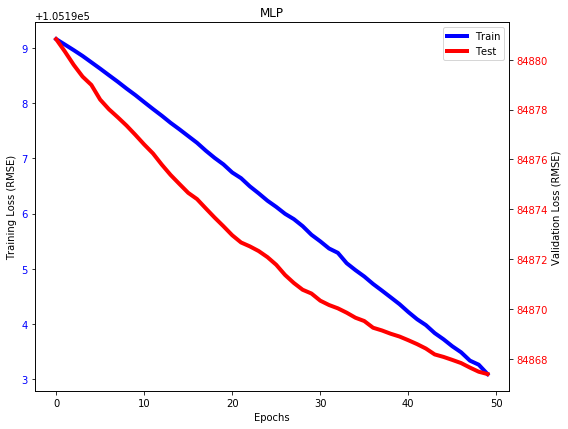

In [17]:
# plot MLP output

loss_train = histdict['loss']
loss_test = histdict['val_loss']
xplot = list(range(len(loss_train)))

fig = plt.figure(num=1, figsize=(8,6))
ax1 = fig.add_subplot(111)
train = ax1.plot(xplot,np.sqrt(loss_train),'b-', label='Train', linewidth=4)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss (RMSE)')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax2 = ax1.twinx()
test = ax2.plot(xplot,np.sqrt(loss_test),'r-',label='Test',linewidth=4)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss (RMSE)')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
curves = train + test
labels = [c.get_label() for c in curves]
ax1.legend(curves, labels, loc=0)
plt.tight_layout()
plt.title('MLP')
plt.savefig('MLPout' + str(epochs) + 'epochs.png')
plt.show()

In [18]:
# build LSTM model

# HYPERPARAMETERS
epochs = 50
batch_size = 100
do = 0.2
Nnodes = 64

main_input = Input(shape=(Ntimesteps,XNfeatures),
                   dtype='float',
                   name='main_input'
                   )

# An LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence

lstm_out = LSTM(Nnodes,  # number of nodes in output dim 
                dropout=do,
                recurrent_dropout=do, 
                use_bias=True, 
                unit_forget_bias=True,  # Jozefowicz et al
                kernel_initializer=Ones(),  # Initializer for weight matrix acting on input 
                recurrent_initializer=Ones(),  # Initializer for hidden state weights
                name='lstm_out'
                )(main_input) 
main_output = Dense(Ntimesteps, name='main_output')(lstm_out)

# feed datasets into model for training
model = Model(inputs=[main_input], 
              outputs=[main_output]
              )

# compile the model with desired configuration
adagrad_custom = Adagrad(clipvalue=1)

# compile the model with desired configuration
model.compile(loss='mean_squared_error',
             optimizer=adagrad_custom,
             metrics=['mae'])

# one of several callbacks available in Keras, csv_logger saves metrics for every epoch to a csv file
csv_logger = CSVLogger('trainingLSTM_' + str(epochs) + '.log')

early_stop = EarlyStopping(monitor='val_loss', # quantity to monitor
                           min_delta=0.001,  # min change to qualify as an improvement
                           patience=10, # stop after #epochs with no improvement
                           verbose=1)  # print messages

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,  # reduction factor (new_lr = lr * factor)
                              patience=5,
                              verbose=1)

# train the model, and store training information in the history object
history = model.fit([X3D_train],[Y3D_train],
                    epochs=epochs,
                    batch_size = batch_size,
                    validation_data=(X3D_test, Y3D_test),
                    callbacks=[csv_logger],
#                    callbacks=[reduce_lr,early_stop,csv_logger]
                    )
histdict = history.history 
model.summary()  # print out a summary of layers/parameters
config = model.get_config()  # detailed information about the configuration of each layer

# evaluate the trained model on the test data set
test = model.evaluate([X3D_test],[Y3D_test],batch_size=batch_size)  
names = model.metrics_names


predict = model.predict([X3D_test],batch_size=batch_size)
Y_3Drmse = np.sqrt(mean_squared_error(predict,Y3D_test))
print('Y_3Drmse:   ',Y_3Drmse)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 1s 1ms/step - loss: 11066801948.4444 - mean_absolute_error: 17969.1436 - val_loss: 7204736000.0000 - val_mean_absolute_error: 18689.7441
Epoch 2/50
900/900 [==============================] - 0s 353us/step - loss: 11066725831.1111 - mean_absolute_error: 17967.0004 - val_loss: 7204676096.0000 - val_mean_absolute_error: 18688.1582
Epoch 3/50
900/900 [==============================] - 0s 338us/step - loss: 11066672156.4444 - mean_absolute_error: 17965.5997 - val_loss: 7204629504.0000 - val_mean_absolute_error: 18686.9316
Epoch 4/50
900/900 [==============================] - 0s 332us/step - loss: 11066631303.1111 - mean_absolute_error: 17964.4643 - val_loss: 7204591616.0000 - val_mean_absolute_error: 18685.8965
Epoch 5/50
900/900 [==============================] - 0s 382us/step - loss: 11066593280.0000 - mean_absolute_error: 17963.4864 - val_loss: 7204557312.0000 - val_mean_absolute_error: 18

900/900 [==============================] - 0s 331us/step - loss: 11065979235.5556 - mean_absolute_error: 17946.3308 - val_loss: 7203928064.0000 - val_mean_absolute_error: 18668.1602
Epoch 44/50
900/900 [==============================] - 0s 319us/step - loss: 11065968270.2222 - mean_absolute_error: 17946.0334 - val_loss: 7203916288.0000 - val_mean_absolute_error: 18667.8652
Epoch 45/50
900/900 [==============================] - 0s 347us/step - loss: 11065957568.0000 - mean_absolute_error: 17945.7398 - val_loss: 7203906048.0000 - val_mean_absolute_error: 18667.5703
Epoch 46/50
900/900 [==============================] - 0s 295us/step - loss: 11065947996.4444 - mean_absolute_error: 17945.4485 - val_loss: 7203895296.0000 - val_mean_absolute_error: 18667.2832
Epoch 47/50
900/900 [==============================] - 0s 288us/step - loss: 11065936469.3333 - mean_absolute_error: 17945.1607 - val_loss: 7203885568.0000 - val_mean_absolute_error: 18666.9980
Epoch 48/50
900/900 [=====================

/home/sousae/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


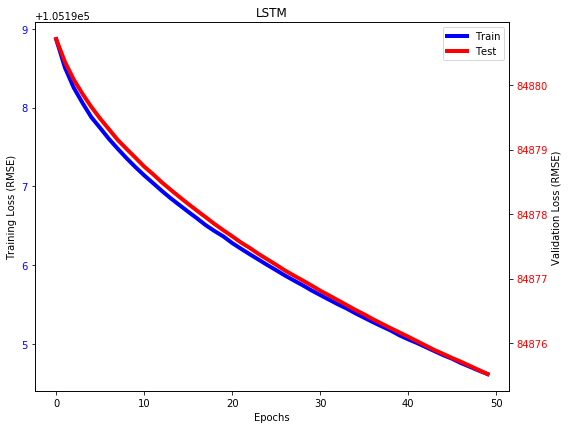

In [19]:
# plot LSTM output

loss_train = histdict['loss']
loss_test = histdict['val_loss']
xplot = list(range(len(loss_train)))

fig = plt.figure(num=2, figsize=(8,6))
ax1 = fig.add_subplot(111)
train = ax1.plot(xplot,np.sqrt(loss_train),'b-', label='Train', linewidth=4)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss (RMSE)')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax2 = ax1.twinx()
test = ax2.plot(xplot,np.sqrt(loss_test),'r-',label='Test',linewidth=4)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss (RMSE)')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
curves = train + test
labels = [c.get_label() for c in curves]
ax1.legend(curves, labels, loc=0)
plt.tight_layout()
plt.title('LSTM')
plt.savefig('LSTMout' + str(epochs) + 'epochs.png')
plt.show()

In [20]:
# build HYBRID model


# HYPERPARAMETERS
epochs = 50
batch_size = 100
do = 0.2
Nnodes = 64

main_input = Input(shape=(Ntimesteps,XNfeatures),
                   dtype='float',
                   name='main_input'
                   )

# An LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence

lstm_out = LSTM(XSNfeatures,  # number of nodes in output dim 
                dropout=do,
                recurrent_dropout=do, 
                use_bias=True, 
                unit_forget_bias=True,  # Jozefowicz et al
                kernel_initializer=Ones(),  # Initializer for weight matrix acting on input 
                recurrent_initializer=Ones(),  # Initializer for hidden state weights
                name='lstm_out'
                )(main_input) 

auxiliary_output = Dense(Ntimesteps, name='aux_output')(lstm_out)

auxiliary_input = Input(shape=(XSNfeatures,), name='aux_input')  # here the shape argument specifies the dimension of each vector i.e. # features.  This needs to match the dimension of the static inputs (None, #static features)
x = Concatenate(axis=-1)([lstm_out, auxiliary_input])  # concat on samples axis maintaining original shapes of both matrices
# =============================================================================
# x = Dense(Nnodes, activation='relu')(x)
# x = BatchNormalization()(x)
# Dropout(0.2)(x)
# =============================================================================
main_output = Dense(Ntimesteps, name='main_output')(x)

# feed datasets into model for training
model = Model(inputs=[main_input,auxiliary_input], 
              outputs=[main_output,auxiliary_output]
              )

# compile the model with desired configuration
model.compile(loss='mean_squared_error',
              optimizer='adagrad',
              metrics=['mae'])

# one of several callbacks available in Keras, csv_logger saves metrics for every epoch to a csv file
csv_logger = CSVLogger('trainingLSTM_' + str(epochs) + '.log')

early_stop = EarlyStopping(monitor='val_loss', # quantity to monitor
                           min_delta=0.001,  # min change to qualify as an improvement
                           patience=10, # stop after #epochs with no improvement
                           verbose=1)  # print messages

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,  # reduction factor (new_lr = lr * factor)
                              patience=5,
                              verbose=1)

# train the model, and store training information in the history object
history = model.fit([X3D_train,XS_train],[Y3D_train,Y3D_train],
                    epochs=epochs,
                    batch_size = batch_size,
                    validation_data=([X3D_test,XS_test],[Y3D_test,Y3D_test]),
                    callbacks=[csv_logger],
#                    callbacks=[reduce_lr,early_stop,csv_logger]
                    )
histdict = history.history 
model.summary()  # print out a summary of layers/parameters
config = model.get_config()  # detailed information about the configuration of each layer

# evaluate the trained model on the test data set
test = model.evaluate([X3D_test,XS_test],[Y3D_test,Y3D_test],batch_size=batch_size)  
names = model.metrics_names

predict = model.predict([X3D_test,XS_test],batch_size=batch_size)
predict = predict[0]
Y_Hybridrmse = np.sqrt(mean_squared_error(predict,Y3D_test))
print('Y_Hybridrmse:   ',Y_Hybridrmse)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 1s 1ms/step - loss: 22133730446.2222 - main_output_loss: 11066863772.4444 - aux_output_loss: 11066867043.5556 - main_output_mean_absolute_error: 17971.4043 - aux_output_mean_absolute_error: 17971.1368 - val_loss: 14409704448.0000 - val_main_output_loss: 7204850688.0000 - val_aux_output_loss: 7204853760.0000 - val_main_output_mean_absolute_error: 18693.2480 - val_aux_output_mean_absolute_error: 18692.9980
Epoch 2/50
900/900 [==============================] - 0s 180us/step - loss: 22133716053.3333 - main_output_loss: 11066856163.5556 - aux_output_loss: 11066859861.3333 - main_output_mean_absolute_error: 17971.1681 - aux_output_mean_absolute_error: 17970.9288 - val_loss: 14409693184.0000 - val_main_output_loss: 7204843520.0000 - val_aux_output_loss: 7204849152.0000 - val_main_output_mean_absolute_error: 18693.0605 - val_aux_output_mean_absolute_error: 18692.8359
Epoch 3/50
900/900 [========

Epoch 19/50
900/900 [==============================] - 0s 244us/step - loss: 22133620992.0000 - main_output_loss: 11066805141.3333 - aux_output_loss: 11066816056.8889 - main_output_mean_absolute_error: 17969.7627 - aux_output_mean_absolute_error: 17969.7006 - val_loss: 14409596928.0000 - val_main_output_loss: 7204792320.0000 - val_aux_output_loss: 7204804608.0000 - val_main_output_mean_absolute_error: 18691.7305 - val_aux_output_mean_absolute_error: 18691.6699
Epoch 20/50
900/900 [==============================] - 0s 214us/step - loss: 22133617265.7778 - main_output_loss: 11066803072.0000 - aux_output_loss: 11066814172.4444 - main_output_mean_absolute_error: 17969.7127 - aux_output_mean_absolute_error: 17969.6566 - val_loss: 14409594880.0000 - val_main_output_loss: 7204791808.0000 - val_aux_output_loss: 7204802560.0000 - val_main_output_mean_absolute_error: 18691.6797 - val_aux_output_mean_absolute_error: 18691.6250
Epoch 21/50
900/900 [==============================] - 0s 231us/step -

Epoch 37/50
900/900 [==============================] - 0s 241us/step - loss: 22133567032.8889 - main_output_loss: 11066776177.7778 - aux_output_loss: 11066791239.1111 - main_output_mean_absolute_error: 17968.9724 - aux_output_mean_absolute_error: 17969.0074 - val_loss: 14409544704.0000 - val_main_output_loss: 7204765696.0000 - val_aux_output_loss: 7204779008.0000 - val_main_output_mean_absolute_error: 18690.9434 - val_aux_output_mean_absolute_error: 18690.9844
Epoch 38/50
900/900 [==============================] - 0s 229us/step - loss: 22133565610.6667 - main_output_loss: 11066776341.3333 - aux_output_loss: 11066789511.1111 - main_output_mean_absolute_error: 17968.9370 - aux_output_mean_absolute_error: 17968.9782 - val_loss: 14409541632.0000 - val_main_output_loss: 7204764160.0000 - val_aux_output_loss: 7204777472.0000 - val_main_output_mean_absolute_error: 18690.9082 - val_aux_output_mean_absolute_error: 18690.9492
Epoch 39/50
900/900 [==============================] - 0s 302us/step -

Y_Hybridrmse:    84880.78624372775


/home/sousae/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


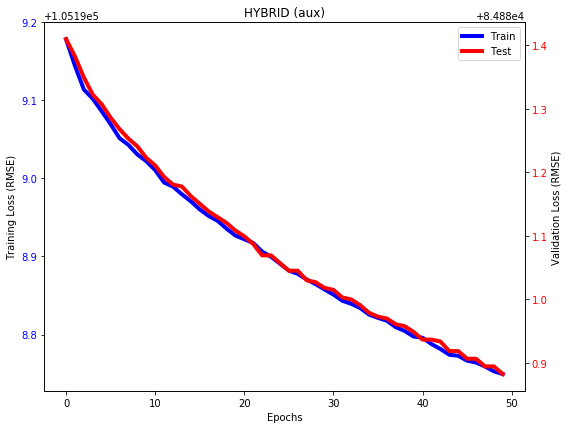

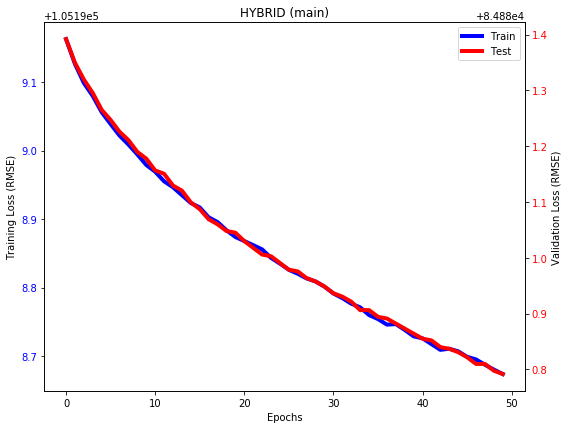

In [21]:
# plot HYBRID output

# aux output
loss_train = histdict['aux_output_loss']
loss_test = histdict['val_aux_output_loss']
xplot = list(range(len(loss_train)))

fig = plt.figure(num=2, figsize=(8,6))
ax1 = fig.add_subplot(111)
train = ax1.plot(xplot,np.sqrt(loss_train),'b-', label='Train', linewidth=4)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss (RMSE)')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax2 = ax1.twinx()
test = ax2.plot(xplot,np.sqrt(loss_test),'r-',label='Test',linewidth=4)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss (RMSE)')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
curves = train + test
labels = [c.get_label() for c in curves]
ax1.legend(curves, labels, loc=0)
plt.tight_layout()
plt.title('HYBRID (aux)')
plt.savefig('HYBRID_aux_out' + str(epochs) + 'epochs.png')
plt.show()

# main output
loss_train = histdict['main_output_loss']
loss_test = histdict['val_main_output_loss']
xplot = list(range(len(loss_train)))

fig = plt.figure(num=3, figsize=(8,6))
ax1 = fig.add_subplot(111)
train = ax1.plot(xplot,np.sqrt(loss_train),'b-', label='Train', linewidth=4)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss (RMSE)')
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax2 = ax1.twinx()
test = ax2.plot(xplot,np.sqrt(loss_test),'r-',label='Test',linewidth=4)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Loss (RMSE)')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
curves = train + test
labels = [c.get_label() for c in curves]
ax1.legend(curves, labels, loc=0)
plt.tight_layout()
plt.title('HYBRID (main)')
plt.savefig('HYBRID_main_out' + str(epochs) + 'epochs.png')
plt.show()
